In [1]:
import numpy as np
import pandas as pd
from EMDPM.model_generator import generate_logistic_model
from EMDPM.synthetic_data_generator import generate_synthetic_data
from EMDPM.visualization import (
    plot_biomarker_trajectories,
    plot_true_observations,
    plot_initial_beta_guess,
    plot_theta_fit_comparison,
    plot_theta_error_history,
    plot_beta_overlay,
    plot_beta_error_history,
    plot_lse,
    plot_cog_regression_history
)
from EMDPM.utils import solve_system
from EMDPM.em_transformer_rework import EM
import matplotlib.pyplot as plt

from statsmodels.formula.api import mixedlm
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input


2025-06-20 07:16:22.010671: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-20 07:16:22.032128: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-20 07:16:22.038738: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-20 07:16:22.056230: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-20 07:16:23.079871: W tensorflow/compiler/tf2

In [2]:
df = pd.read_csv("/data01/bgutman/MRI_data/PPMI/data_ppmi_pd.csv")
df_K = pd.read_csv("/data01/bgutman/LEGACY/Skoltech/datasets/Connectomes/mean_NORM_con_full.csv")

## remove non-longitudinal observations
print("original size:", df.shape)
relevant_cols = [col for col in df.columns if col.startswith(('L_', 'R_')) and ('_thickavg' in col or '_thickavg_resid' in col)]
relevant_cols += ["MCATOT", "TD_score", "PIGD_score"]
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=relevant_cols)

print("after drop na", df.shape)
subj_counts = df['subj_id'].value_counts()
num_unique = (subj_counts == 1).sum()
print("one time subj_id:", num_unique)

longitudinal_ids = subj_counts[subj_counts > 1].index
df = df[df['subj_id'].isin(longitudinal_ids)].copy()
df = df.drop_duplicates(subset=["subj_id", "time"])
print("after drop dupes", df.shape)

small_region_set = ['L_inferiorparietal_thickavg',
'R_inferiorparietal_thickavg',
'L_inferiortemporal_thickavg',
'R_inferiortemporal_thickavg',
'L_precuneus_thickavg',
'R_precuneus_thickavg',
'L_isthmuscingulate_thickavg',
'R_isthmuscingulate_thickavg',
'L_lateraloccipital_thickavg',
'R_lateraloccipital_thickavg']


X = df[small_region_set]
X_resid = df[[col for col in df.columns if (col.startswith(('L_', 'R_')) and col.endswith('_thickavg_resid'))]]

cool_idx = [6, 40, 7, 41, 23, 57, 8, 42, 9, 43]

X = X.to_numpy()
#X = X[:,cool_idx]

X_resid = X_resid.to_numpy()

print("nans in X:", np.isnan(X).sum())
print("infs in X:", np.isinf(X).sum())

print("nans X_resid:", np.isnan(X_resid).sum())
print("infs X_resid:", np.isinf(X_resid).sum())

## connectivity matrix to numpy
K = df_K.drop(df_K.columns[0], axis=1).to_numpy()
np.fill_diagonal(K, 0)
print(K.shape, type(K))

# normalization
row_sums = K.sum(axis=1)
median_row_sum = np.median(row_sums)
K = K / median_row_sum

K = np.take(np.take(K,cool_idx,axis=0), cool_idx, axis=1)

t_max = 20
step = 0.001

print(K.shape)

print("X.size: ", X.shape, "X_resid.size: ", X_resid.shape)

ids = df["subj_id"].to_numpy()
dt = df["time"].to_numpy()/12 # convert to years
#cog = df["MCATOT"].values#,"TD_score","PIGD_score"]].values
cog = df[["MCATOT","TD_score","PIGD_score"]].to_numpy()

print("nans in cog:", np.isnan(cog).sum())
print("infs in cog:", np.isinf(cog).sum())

original size: (880, 250)
after drop na (868, 250)
one time subj_id: 227
after drop dupes (504, 250)
nans in X: 0
infs in X: 0
nans X_resid: 0
infs X_resid: 0
(68, 68) <class 'numpy.ndarray'>
(10, 10)
X.size:  (504, 10) X_resid.size:  (504, 68)
nans in cog: 0
infs in cog: 0


         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: time_years
No. Observations: 504     Method:             REML      
No. Groups:       146     Scale:              2.0152    
Min. group size:  2       Log-Likelihood:     -900.0355 
Max. group size:  4       Converged:          Yes       
Mean group size:  3.5                                   
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      1.497    0.690  2.169 0.030  0.145  2.850
MCATOT        -0.002    0.024 -0.093 0.926 -0.050  0.046
PIGD_score     0.127    0.032  3.994 0.000  0.065  0.189
TD_score      -0.010    0.016 -0.607 0.544 -0.041  0.022
Group Var      0.000                                    



/home/dsemchin/miniconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/dsemchin/miniconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


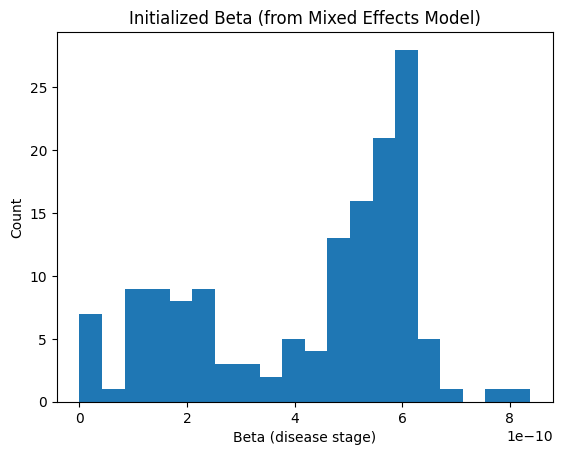

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.formula.api import mixedlm
import pandas as pd

# Select relevant columns
df_cog = df[["subj_id", "time", "MCATOT", "PIGD_score", "TD_score"]].copy()

# Convert time to years
df_cog["time_years"] = df_cog["time"] / 12

# Drop rows with missing values in any of the relevant columns
df_cog.dropna(subset=["time_years", "MCATOT", "PIGD_score", "TD_score"], inplace=True)

# Fit mixed effects model: time as response, others as predictors
model = mixedlm("time_years ~ MCATOT + PIGD_score + TD_score", 
                data=df_cog, 
                groups=df_cog["subj_id"],
                re_formula="1")  # random intercept only

result = model.fit()
print(result.summary())

# Extract random intercepts as proxy for disease stage (lower intercept ~ earlier stage)
random_effects = result.random_effects
id_to_intercept = {pid: re["Group"] for pid, re in random_effects.items()}
unique_ids = np.unique(df["subj_id"])
beta_init = np.array([id_to_intercept.get(pid, 0.0) for pid in unique_ids])

if min(beta_init) < 0:
    beta_init += np.abs(min(beta_init))

plt.hist(beta_init, bins=20)
plt.title("Initialized Beta (from Mixed Effects Model)")
plt.xlabel("Beta (disease stage)")
plt.ylabel("Count")
plt.show()


In [11]:
path = "/home/dsemchin/Progression_models_simulations/EMDPM/experiments/real_data_PPMI/ppmi_iter10_test"
em_model_0 = EM(num_iterations=3, t_max=40, step=step,
                 use_jacobian=True, lambda_cog=0.3, lambda_f=0.1, lambda_scalar=0.0)
em_model_0.fit(X=X, dt=dt, ids=ids, cog=cog, K=K, save_path=path, initial_beta=beta_init)

initial conditions:
n_patients: 146, n_obs: 504
initial f: [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602 ]
initial s: [1.29863068 2.48683136 0.16573133 0.5031427  2.95964328 2.98186855
 2.48212827 2.54551839 1.26382145 2.03467892]
initial scalar K: 2.977
initial beta: (146,)
prepend complete


100%|██████████| 3/3 [00:24<00:00,  8.08s/it]


SUMMARY:
initial theta:  [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602 ]
final theta:  [1.14152486 0.79508841 0.50628747 1.1760737  0.1166841  0.00433031
 0.05380275 0.00984198 1.21063264 0.01025581]
Saved histories to /home/dsemchin/Progression_models_simulations/EMDPM/experiments/real_data_PPMI/ppmi_iter10_test.npz


EM(lambda_cog=0.3, lambda_f=0.1, num_iterations=3,
   rng=Generator(PCG64) at 0x7F9794472960, step=0.001, t_max=40,
   use_jacobian=True)

initial theta:
f:  [0.021 0.015 0.066 0.068 0.093 0.075 0.093 0.095 0.087 0.001]
s:  [1.299 2.487 0.166 0.503 2.96  2.982 2.482 2.546 1.264 2.035]
s0:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
s_k:  2.977
final theta:
f:  [1.142 0.795 0.506 1.176 0.117 0.004 0.054 0.01  1.211 0.01 ]
s:  [1.848 2.393 0.949 1.365 2.436 2.452 2.278 2.282 1.74  2.161]
s0:  [ 0.475 -0.021  1.689  1.318 -0.121 -0.12  -0.073 -0.088  0.416  0.065]
s_k:  2.977485281071459
(31,)
n_zeros: 0


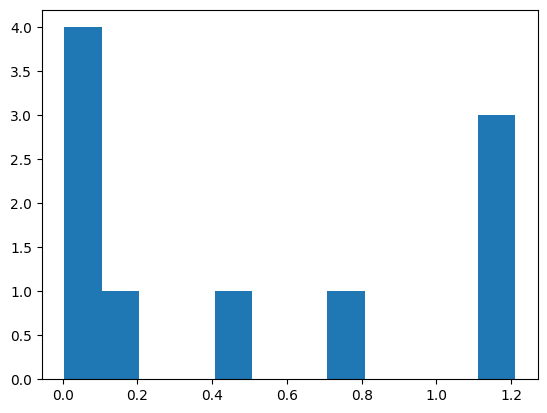

/home/dsemchin/Progression_models_simulations/EMDPM/visualization.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()



BETA SUMMARY:
beta initial:  [28.027  29.2698 26.5926 28.7681 27.9831 28.0252 27.8284 26.9727 29.5929
 27.4131]
beta final:  [28.027  29.2698 26.3303 28.4807 27.7351 28.0252 27.8284 26.6764 29.4521
 27.2464]


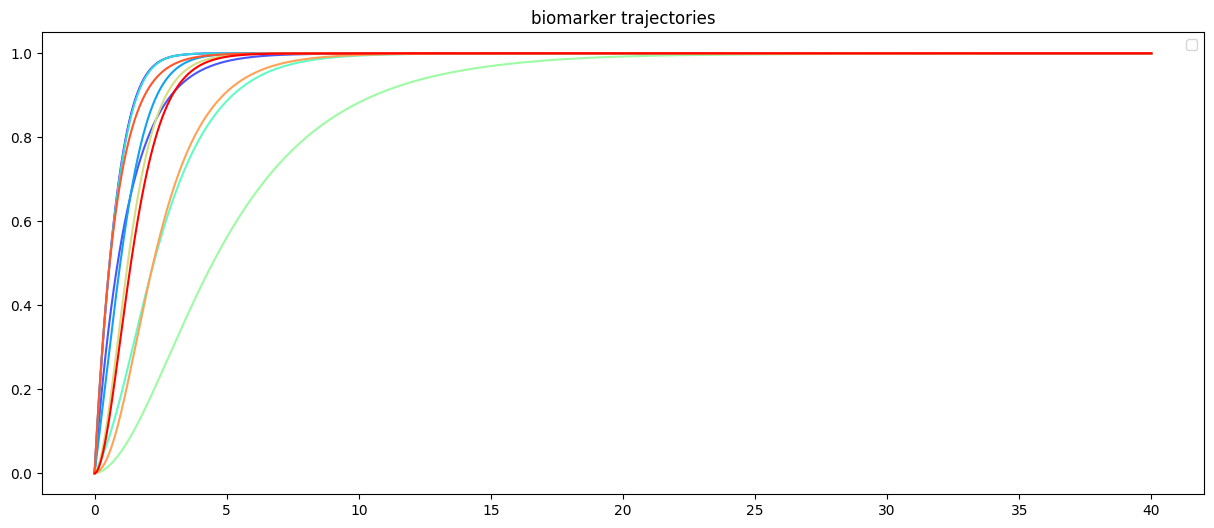

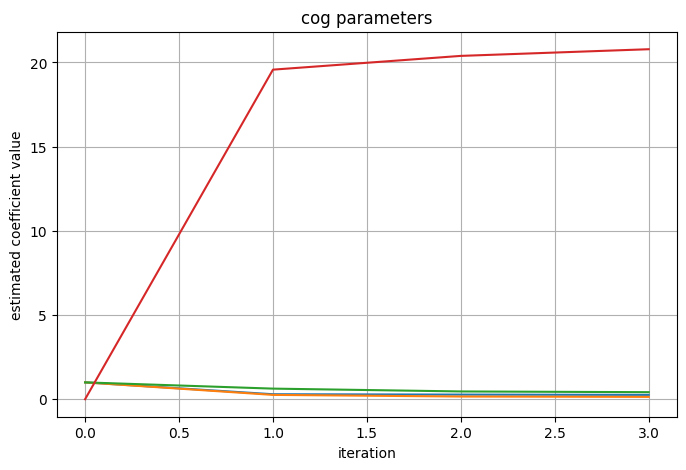

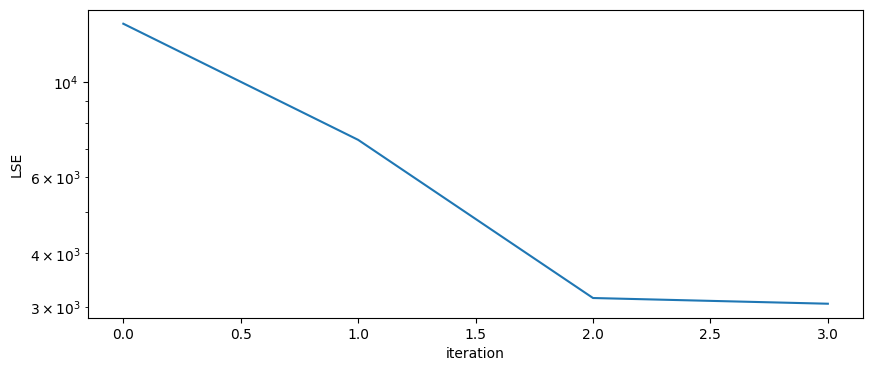

In [12]:
n_biomarkers = 10
t_span = np.linspace(0, 40, int(40/step))

theta_history = em_model_0.theta_history
beta_history = em_model_0.beta_history
lse_history = em_model_0.lse_history

# final params
final_theta = theta_history[:,-1]
final_x0 = np.zeros(n_biomarkers)
final_f = final_theta[0:n_biomarkers]
final_s = final_theta[n_biomarkers:2*n_biomarkers]
final_s0 = final_theta[2*n_biomarkers:3*n_biomarkers]
final_scalar_K = final_theta[-1]

final_model = solve_system(final_x0, final_f, K, t_span, final_scalar_K)

initial_theta = theta_history[:,0]
initial_x0 = np.zeros(n_biomarkers)
initial_f = initial_theta[0:n_biomarkers]
initial_s = initial_theta[n_biomarkers:2*n_biomarkers]
initial_scalar_K = initial_theta[-1]
#initial_model = solve_system(initial_x0, initial_f, K, t_span, initial_scalar_K)

print("initial theta:")
print("f: ", np.round(initial_theta[:n_biomarkers],3))
print("s: ", np.round(initial_theta[n_biomarkers:2*n_biomarkers],3))
print("s0: ", np.round(initial_theta[2*n_biomarkers:3*n_biomarkers],3))
print("s_k: ", initial_theta[-1])

print("final theta:")
print("f: ", np.round(final_theta[:n_biomarkers],3))
print("s: ", np.round(final_theta[n_biomarkers:2*n_biomarkers], 3))
print("s0: ", np.round(final_theta[2*n_biomarkers:3*n_biomarkers],3))
print("s_k: ", final_theta[-1])


print(final_theta.shape)

zeros = np.sum(final_theta[:n_biomarkers] == 0.0)
print(f"n_zeros: {zeros}")
plt.figure()
plt.hist(final_theta[:n_biomarkers], bins=12) 
plt.show()

## Beta comparison:
print("\nBETA SUMMARY:")
print("beta initial: ", np.round(beta_history[0:10, 0],4))
print("beta final: ", np.round(beta_history[0:10, -1], 4))

plot_biomarker_trajectories(final_model, t_span, n_biomarkers)
plot_cog_regression_history(em_model_0.cog_regression_history, ["MCATOT","TD_score","PIGD_score"])
plot_lse(lse_history)

In [13]:
tmax=40
path = "/home/dsemchin/Progression_models_simulations/EMDPM/experiments/real_data_PPMI/ppmi_iter50_jac1_cog0_f01_sk01_betaREG"
em_model_1 = EM(num_iterations=3, t_max=tmax, step=step,
                 use_jacobian=True, lambda_cog=0.3, lambda_f=0.1, lambda_scalar=0.0)
em_model_1.fit(X=X, dt=dt, ids=ids, cog=cog, K=K, save_path=path, initial_beta=beta_init)

initial conditions:
n_patients: 146, n_obs: 504
initial f: [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602 ]
initial s: [1.29863068 2.48683136 0.16573133 0.5031427  2.95964328 2.98186855
 2.48212827 2.54551839 1.26382145 2.03467892]
initial scalar K: 2.977
initial beta: (146,)
prepend complete


100%|██████████| 3/3 [00:17<00:00,  5.73s/it]


SUMMARY:
initial theta:  [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602 ]
final theta:  [1.3344226  0.98235053 0.70791972 1.36122337 0.30091252 0.20107333
 0.00757742 0.04355785 1.39845954 0.20970217]
Saved histories to /home/dsemchin/Progression_models_simulations/EMDPM/experiments/real_data_PPMI/ppmi_iter50_jac1_cog0_f01_sk01_betaREG.npz


EM(lambda_cog=0.3, lambda_f=0.1, num_iterations=3,
   rng=Generator(PCG64) at 0x7F979425B840, step=0.001, t_max=40,
   use_jacobian=True)

initial theta:
f:  [0.021 0.015 0.066 0.068 0.093 0.075 0.093 0.095 0.087 0.001]
s:  [1.299 2.487 0.166 0.503 2.96  2.982 2.482 2.546 1.264 2.035]
s_k:  2.977
final theta:
f:  [1.334 0.982 0.708 1.361 0.301 0.201 0.008 0.044 1.398 0.21 ]
s:  [1.848 2.393 0.951 1.367 2.436 2.451 2.277 2.281 1.743 2.161]
s_k:  2.9772309964212162
n_zeros: 0


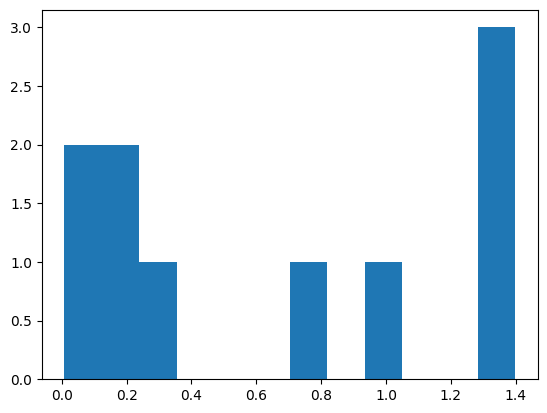


BETA SUMMARY:
beta initial:  [28.027 29.27  26.33  28.481 27.735 28.025 27.828 26.676 29.452 27.246]
beta final:  [27.867 29.27  26.139 28.193 27.735 28.025 27.828 26.597 29.452 27.134]


/home/dsemchin/Progression_models_simulations/EMDPM/visualization.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


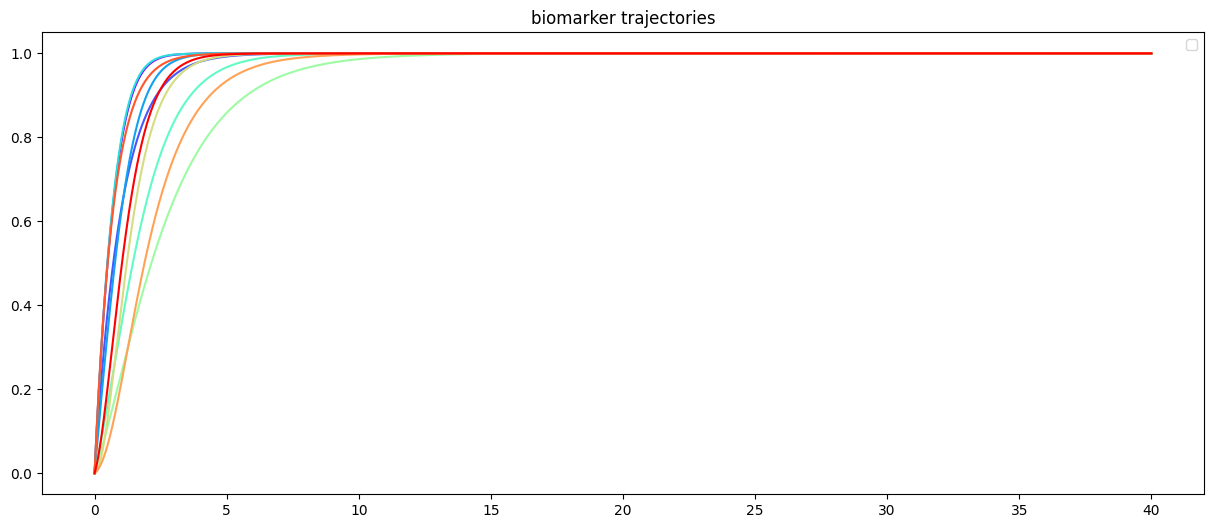

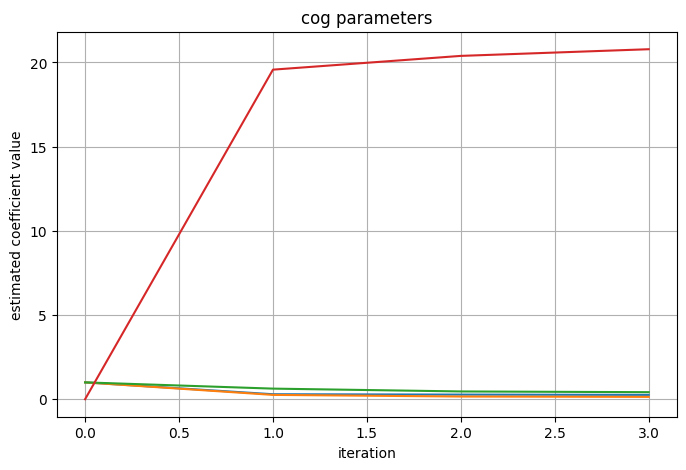

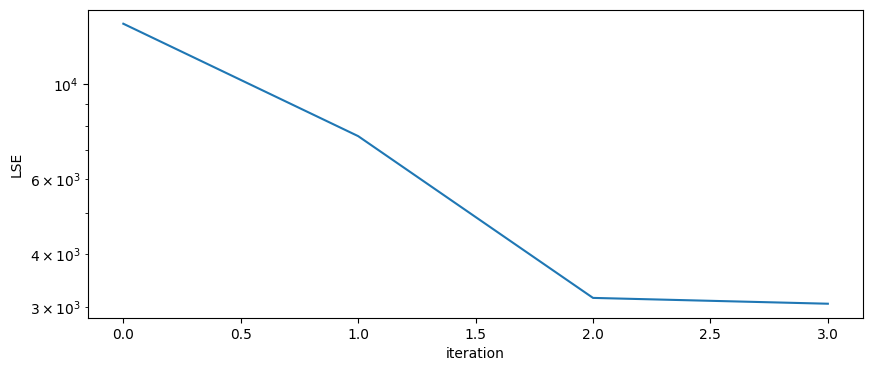

In [14]:
n_biomarkers = 10
t_span = np.linspace(0, 40, int(40/step))

theta_history = em_model_1.theta_history
beta_history = em_model_1.beta_history
lse_history = em_model_1.lse_history

# final params
final_theta = theta_history[:,-1]
final_x0 = np.zeros(n_biomarkers)
final_f = final_theta[0:n_biomarkers]
final_s = final_theta[n_biomarkers:2*n_biomarkers]
final_scalar_K = final_theta[-1]
final_model = solve_system(final_x0, final_f, K, t_span, final_scalar_K)

initial_theta = theta_history[:,0]
initial_x0 = np.zeros(n_biomarkers)
initial_f = initial_theta[0:n_biomarkers]
initial_s = initial_theta[n_biomarkers:2*n_biomarkers]
initial_scalar_K = initial_theta[-1]
#initial_model = solve_system(initial_x0, initial_f, K, t_span, initial_scalar_K)

print("initial theta:")
print("f: ", np.round(initial_theta[:n_biomarkers], 3)[0:10])
print("s: ", np.round(initial_theta[n_biomarkers:2*n_biomarkers], 3)[0:10])
print("s_k: ", initial_theta[-1])

print("final theta:")
print("f: ", np.round(final_theta[:n_biomarkers], 3)[0:10])
print("s: ", np.round(final_theta[n_biomarkers:2*n_biomarkers], 3)[0:10])
print("s_k: ", final_theta[-1])

zeros = np.sum(final_theta[:n_biomarkers] == 0.0)
print(f"n_zeros: {zeros}")
plt.figure()
plt.hist(final_theta[:n_biomarkers], bins=12) 
plt.show()

## Beta comparison:
print("\nBETA SUMMARY:")
print("beta initial: ", np.round(beta_history[0:10, 0], 3))
print("beta final: ", np.round(beta_history[0:10, -1], 3))

plot_biomarker_trajectories(final_model, t_span, n_biomarkers)
plot_cog_regression_history(em_model_0.cog_regression_history, ["MCATOT","TD_score","PIGD_score"])
plot_lse(lse_history)

In [8]:
path = "/home/dsemchin/Progression_models_simulations/EMDPM/experiments/real_data_PPMI/ppmi_iter50_jac1_cog0_f01_sk1_betaREG"
em_model_2 = EM(num_iterations=50, t_max=t_max, step=step,
                 use_jacobian=True, lambda_cog=0.0, lambda_f=0.1, lambda_scalar=1)
em_model_2.fit(X=X, dt=dt, ids=ids, cog=cog, K=K, save_path=path, initial_beta=beta_init_reg)

NameError: name 'beta_init_reg' is not defined

initial theta:
f:  [0.021 0.015 0.066 0.068 0.093 0.075 0.093 0.095 0.087 0.001]
s:  [0.107 0.283 2.166 1.099 1.784 2.159 1.362 1.691 2.167 1.005]
s_k:  4.149
final theta:
f:  [0.178 0.552 0.    0.968 0.367 0.718 0.089 0.199 0.215 0.157]
s:  [2.386 2.335 2.437 1.897 3.137 2.624 2.324 2.639 2.205 2.156]
s_k:  0.8891622848533116
n_zeros: 5


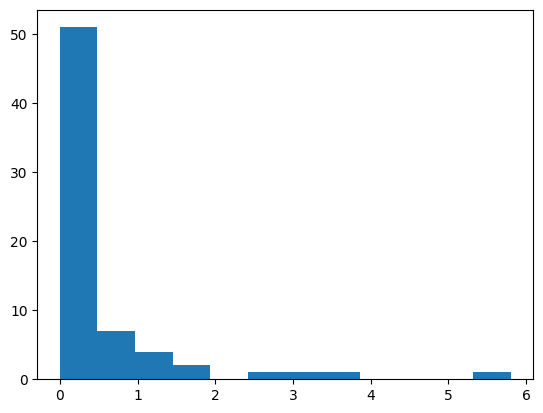


BETA SUMMARY:
beta initial:  [ 9.89  14.91  13.205 20.    10.455 12.503 20.    11.949 18.422 16.902]
beta final:  [ 9.89  14.91  13.205 20.    10.455 12.503 20.    11.949 18.422 16.902]


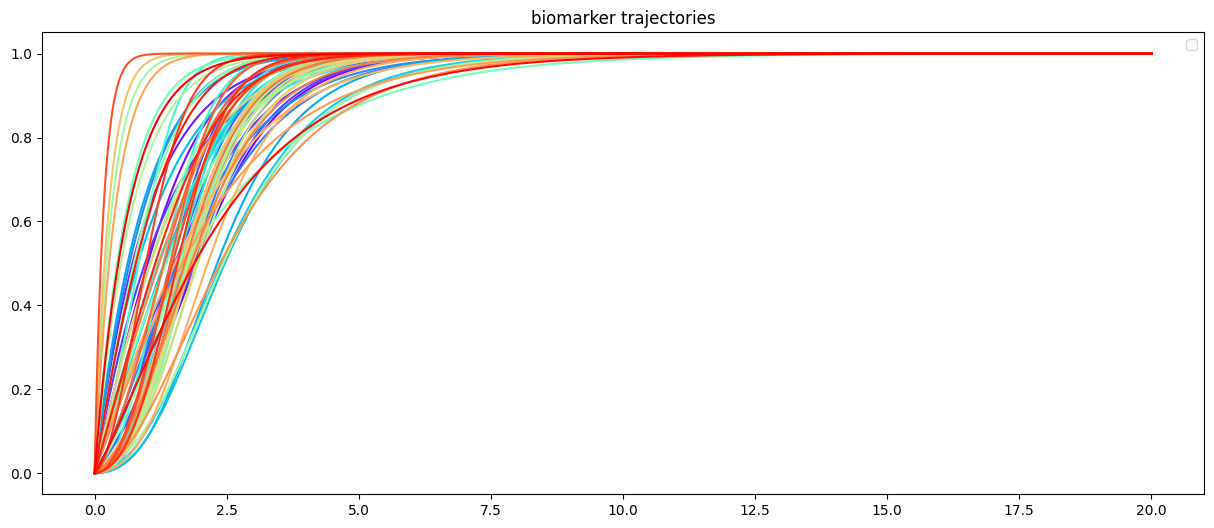

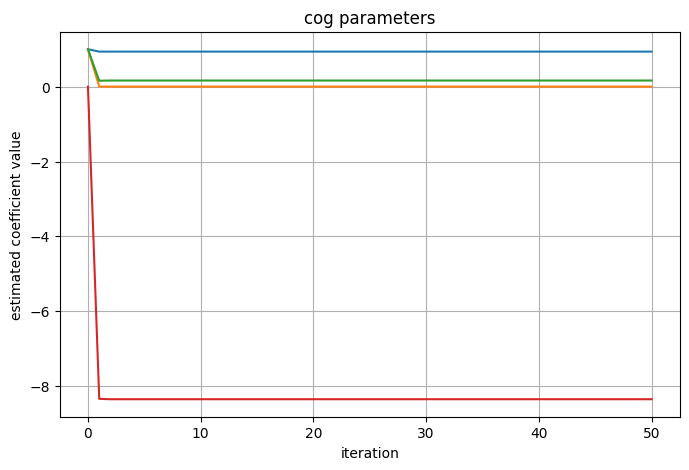

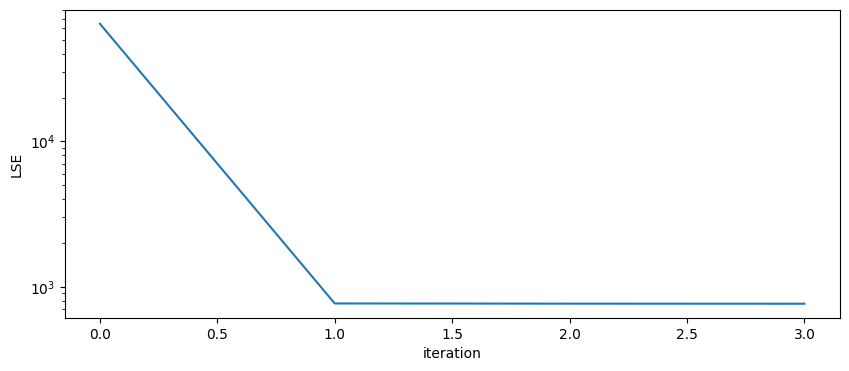

In [ ]:
n_biomarkers = 68
t_span = np.linspace(0, t_max, int(t_max/step))

theta_history = em_model_2.theta_history
beta_history = em_model_2.beta_history
lse_history = em_model_2.lse_history

# final params
final_theta = theta_history[:,-1]
final_x0 = np.zeros(n_biomarkers)
final_f = final_theta[0:n_biomarkers]
final_s = final_theta[n_biomarkers:2*n_biomarkers]
final_scalar_K = final_theta[-1]
final_model = solve_system(final_x0, final_f, K, t_span, final_scalar_K)

initial_theta = theta_history[:,0]
initial_x0 = np.zeros(n_biomarkers)
initial_f = initial_theta[0:n_biomarkers]
initial_s = initial_theta[n_biomarkers:2*n_biomarkers]
initial_scalar_K = initial_theta[-1]
#initial_model = solve_system(initial_x0, initial_f, K, t_span, initial_scalar_K)

print("initial theta:")
print("f: ", np.round(initial_theta[:n_biomarkers], 3)[0:10])
print("s: ", np.round(initial_theta[n_biomarkers:2*n_biomarkers], 3)[0:10])
print("s_k: ", initial_theta[-1])

print("final theta:")
print("f: ", np.round(final_theta[:n_biomarkers], 3)[0:10])
print("s: ", np.round(final_theta[n_biomarkers:2*n_biomarkers], 3)[0:10])
print("s_k: ", final_theta[-1])

zeros = np.sum(final_theta[:n_biomarkers] == 0.0)
print(f"n_zeros: {zeros}")
plt.figure()
plt.hist(final_theta[:n_biomarkers], bins=12) 
plt.show()

## Beta comparison:
print("\nBETA SUMMARY:")
print("beta initial: ", np.round(beta_history[0:10, 0], 3))
print("beta final: ", np.round(beta_history[0:10, -1], 3))

plot_biomarker_trajectories(final_model, t_span, n_biomarkers)
plot_cog_regression_history(em_model_0.cog_regression_history, ["MCATOT","TD_score","PIGD_score"])
plot_lse(lse_history[0:4])

In [ ]:
path = "/home/dsemchin/Progression_models_simulations/EMDPM/experiments/real_data_PPMI/ppmi_iter50_jac0_cog01_f05_sk1_betaREG"
em_model_3 = EM(num_iterations=50, t_max=t_max, step=step,
                 use_jacobian=False, lambda_cog=0.1, lambda_f=0.5, lambda_scalar=1)
em_model_3.fit(X=X, dt=dt, ids=ids, cog=cog, K=K, save_path=path, initial_beta=beta_init_reg)

initial conditions:
n_patients: 146, n_obs: 504
initial f: [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602  0.04133209 0.08230453
 0.0022666  0.01390147 0.09860839 0.09937478 0.08214235 0.08432822
 0.04013177 0.06671307 0.08373361 0.09839783 0.02023919 0.03501122
 0.04284144 0.01783596 0.09961038 0.09075806 0.02514527 0.00911193
 0.08359398 0.01764515 0.01661423 0.07885973 0.07766215 0.04404987
 0.09696822 0.082177   0.05962018 0.00122331 0.05374854 0.04256232
 0.04619497 0.04704044 0.02556865 0.01364169 0.04599744 0.07974691
 0.07593373 0.03570143 0.06885477 0.07627636 0.07265386 0.08249544
 0.09601051 0.04935155 0.06479739 0.06791427 0.02254441 0.00444622
 0.03445908 0.07018692 0.06961764 0.09191688 0.02265776 0.09207324
 0.06548166 0.07676195]
initial s: [0.10711755 0.28260825 2.16554111 1.09902366 1.78421727 2.15874837
 1.36243194 1.69084338 2.16695433 1.00498682 0.94543585 1.55525368
 2.5998545  1.57441885 1.22037802 2.6

  4%|▍         | 2/50 [14:05<5:20:20, 400.43s/it]

  6%|▌         | 3/50 [14:16<2:54:25, 222.66s/it]

 88%|████████▊ | 44/50 [1:07:47<07:49, 78.27s/it]

initial theta:
f:  [0.021 0.015 0.066 0.068 0.093 0.075 0.093 0.095 0.087 0.001]
s:  [0.107 0.283 2.166 1.099 1.784 2.159 1.362 1.691 2.167 1.005]
s_k:  4.149
final theta:
f:  [0.    0.029 0.064 0.905 0.048 1.843 0.067 0.008 0.037 0.005]
s:  [2.386 2.335 2.437 1.898 3.137 2.624 2.323 2.639 2.205 2.156]
s_k:  1.9686325519747965
n_zeros: 11


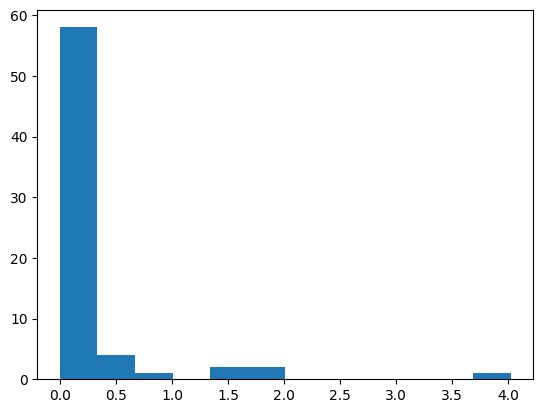


BETA SUMMARY:
beta initial:  [ 8. 20.  7.  7. 20. 20. 20. 20. 20. 20.]
beta final:  [ 8. 20.  7.  7. 20. 20. 20. 20. 20. 20.]


/home/dsemchin/Progression_models_simulations/EMDPM/visualization.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


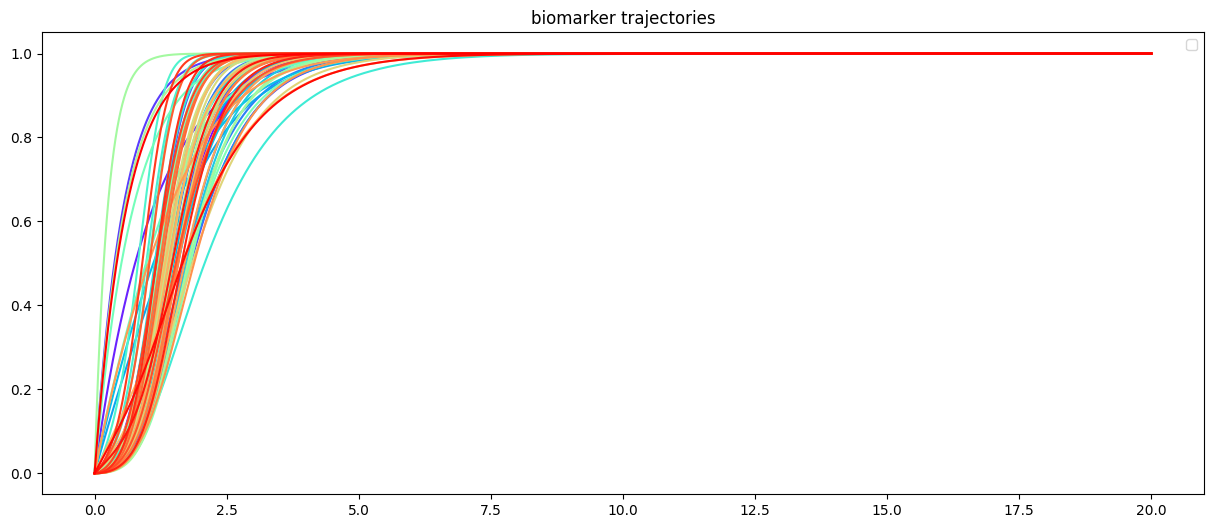

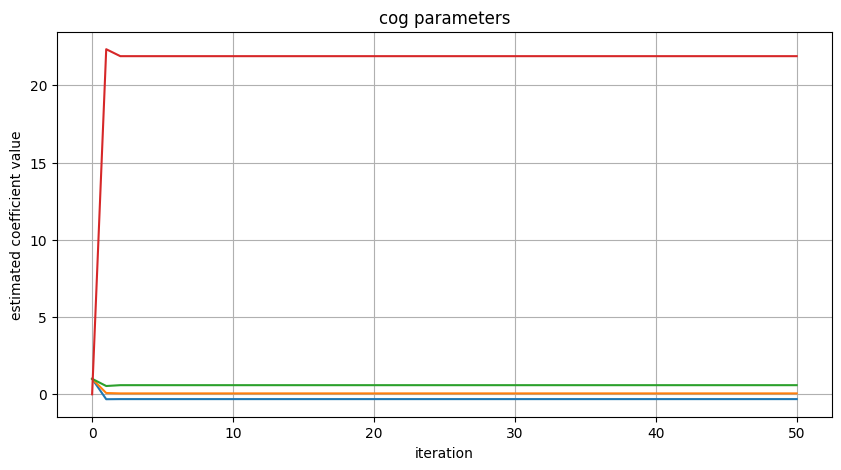

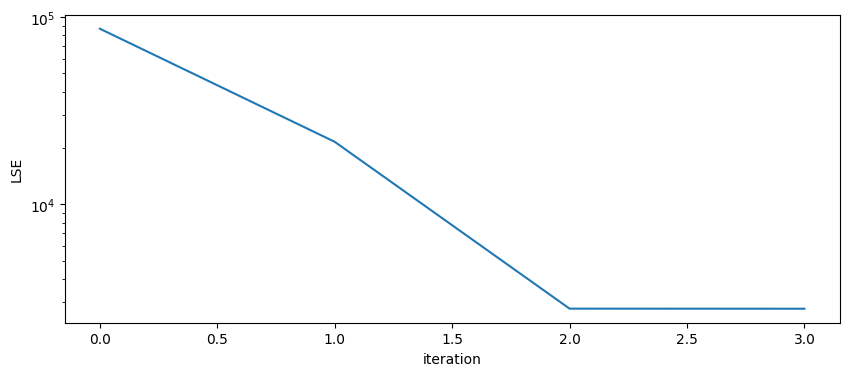

In [ ]:
n_biomarkers = 68
t_span = np.linspace(0, t_max, int(t_max/step))

theta_history = em_model_3.theta_history
beta_history = em_model_3.beta_history
lse_history = em_model_3.lse_history

# final params
final_theta = theta_history[:,-1]
final_x0 = np.zeros(n_biomarkers)
final_f = final_theta[0:n_biomarkers]
final_s = final_theta[n_biomarkers:2*n_biomarkers]
final_scalar_K = final_theta[-1]
final_model = solve_system(final_x0, final_f, K, t_span, final_scalar_K)

initial_theta = theta_history[:,0]
initial_x0 = np.zeros(n_biomarkers)
initial_f = initial_theta[0:n_biomarkers]
initial_s = initial_theta[n_biomarkers:2*n_biomarkers]
initial_scalar_K = initial_theta[-1]
#initial_model = solve_system(initial_x0, initial_f, K, t_span, initial_scalar_K)

print("initial theta:")
print("f: ", np.round(initial_theta[:n_biomarkers], 3)[0:10])
print("s: ", np.round(initial_theta[n_biomarkers:2*n_biomarkers], 3)[0:10])
print("s_k: ", initial_theta[-1])

print("final theta:")
print("f: ", np.round(final_theta[:n_biomarkers], 3)[0:10])
print("s: ", np.round(final_theta[n_biomarkers:2*n_biomarkers], 3)[0:10])
print("s_k: ", final_theta[-1])

zeros = np.sum(final_theta[:n_biomarkers] == 0.0)
print(f"n_zeros: {zeros}")
plt.figure()
plt.hist(final_theta[:n_biomarkers], bins=12) 
plt.show()

## Beta comparison:
print("\nBETA SUMMARY:")
print("beta initial: ", np.round(beta_history[0:10, 0], 3))
print("beta final: ", np.round(beta_history[0:10, -1], 3))

plot_biomarker_trajectories(final_model, t_span, n_biomarkers)
plot_cog_regression_history(em_model_3.cog_regression_history, ["MCATOT","TD_score","PIGD_score"])
plot_lse(lse_history[0:4])